# TP1: Parcours de protons dans la matière
## PHY-3500: Physique numérique (H2021) - 19 février 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import sympy as sym 
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt

### Question 1

On cherche à exprimer la densité électronique $n_{e}$ en fonction de sa composition atomique et de sa masse volumique $\rho$. On peut d'abord consulter les données du NIST afin de connaître les compositions atomiques de l'eau et de l'os compact ainsi que les énergies moyennes d'excitation $I$.  

On identifie pour l'eau (liquide):
- Densité $\rho$ (g/cm$^{3}$) = 1.00E+00
- Énergie d'excitation moyenne (eV) = 75.00
- Composition:
     - Numéro atomique 1 = 0.111894 (fraction par poids)
     - Numéro atomique 8 = 0.888106 (fraction par poids)

On identifie pour l'os compact (ICRU):
- Densité $\rho$ (g/cm$^{3}$) = 1.85E+00
- Énergie d'excitation moyenne (eV) = 91.90
- Composition:
    - Numéro atomique 1 = 0.063984
    - Numéro atomique 6 = 0.278000
    - Numéro atomique 7 = 0.027000
    - Numéro atomique 8 = 0.410016
    - Numéro atomique 12 = 0.002000
    - Numéro atomique 15 = 0.070000
    - Numéro atomique 16 = 0.002000
    - Numéro atomique 20 = 0.147000

On sait que la densité électronique d'un matériau peut être déterminé à l'aide de la formule suivante (https://en.wikipedia.org/wiki/Bethe_formula):

$$ n_e = \dfrac{N_A \cdot Z \cdot \rho}{A\cdot M_u}, $$

où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $A$ est la masse atomique relative et $M_u$ est la constante de masse molaire qui vaut 1 g/mol. 

Comme les matériaux observés sont composés de plusieurs éléments différents, on peut réécrire la densité électronique de la façon suivante:

$$ n_e = \dfrac{N_A \rho}{M_u} \sum_{i} \dfrac{Z_i \xi_{i}}{A_{i}}, $$

où $\xi$ est l'abondance relative de l'élément $i$ (Physique atomique et nucléaire, Jean-François Fortin). 

Par ailleurs, on sait que l'énergie cinétique est liée au facteur $\gamma$ de Lorentz de la façon suivante :

$$T = (\gamma - 1) m_0 c^2,$$

alors, on a évidemment que

$$\implies \gamma = \frac{T}{m_0 c^2} + 1.$$

On peut aussi lié les facteurs $\gamma$ et $\beta$ de Lorentz en sachant que

$$\gamma = \frac{1}{\sqrt{1 - \beta^2}},$$

et donc que

$$\implies \beta = \sqrt{1 - \frac{1}{\gamma^2}}.$$

On implémente l'ensemble des propriétés des deux milieux à l'étude dans une classe nommée « Medium ». Le calcul du pouvoir d'arrêt collisionnel sera réalisé dans cette classe.

In [4]:
class Medium:
    """
    Cette classe définit les propriétés des matériaux
    dans lesquels les protons sont propagés.
    """
    
    # Densité des milieux (rho) [g/cm^3]
    _densities: dict = {
        'Water': 1.0,
        'ICRU': 1.85
    }
    
    # Énergies moyennes d'excitation (I) [eV]
    _mean_excitation_energies: dict = {
        'Water': 75.00,
        'ICRU': 91.90
    }
    
    # Masse atomique relative de l'élément i (A_i) [-]
    _relative_atomic_mass: dict = {
        1: 1.00784,
        6: 12.0107,
        7: 14.0067,
        8: 15.999,
        12: 24.305,
        15: 30.9738,
        16: 32.065,
        20: 40.078,
    }
    
    # Composition de l'eau (Abondance relative, Xi) [-]
    _composition_water: dict = {
        1: 0.111894,
        8: 0.888106,
    }
    
    # Composition de l'os compact (Abondance relative, Xi) [-]
    _composition_ICRU: dict = {
        1: 0.063984,
        6: 0.278000,
        7: 0.027000,
        8: 0.410016,
        12: 0.002000,
        15: 0.070000,
        16: 0.002000,
        20: 0.147000,
    }
    
    # Dictionnaire des compositions
    _compositions: dict = {
        'Water': _composition_water,
        'ICRU': _composition_ICRU
    }
        
    
    def __init__(self, name: str) -> None:
        """
        Constructeur de la classe Medium.
        :param name: Nom du milieu dans lequel s'effectue la propagation
        """

        self.name: str = name
        
                
    @property
    def name(self) -> str:
        """
        Name property.
        :return: Nom du milieu (str)
        """
        
        return self._name
    
    
    @name.setter
    def name(self, name: str) -> None:
        """
        Setter de l'attribut name.
        :param name: Nom du milieu dans lequel s'effectue la propagation
        """
        
        if name not in Medium._compositions:
            raise NameError("Le matériau choisi n'est pas défini dans la classe. Choisir un autre matériau tel {}."
                            .format(list(Medium._compositions.keys())))
        else:
            self._composition: dict = Medium._compositions[name]
            self._mean_excitation_energy: float = Medium._mean_excitation_energies[name]
            self._density: float = Medium._densities[name]
        self._name = name
        
    
    @property
    def composition(self) -> dict:
        """
        Composition property.
        :return: Composition du milieu (dict)
        """
        
        return self._composition
    
    
    @property
    def mean_excitation_energy(self) -> float:
        """
        Mean excitation energy property.
        :return: Énergie d'excitation moyenne du milieu (float)
        """
        
        return self._mean_excitation_energy
    
    
    @property
    def density(self) -> float:
        """
        Density property.
        :return: Densité du milieu (float)
        """
        
        return self._density
    
    
    @staticmethod
    def get_gamma(T):
        """
        Getter du facteur gamma.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur gamma. (float or np.ndarray)
        """
        
        m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0]
        return T/(m_p) + 1.0
    
    
    @staticmethod
    def get_beta(T):
        """
        Getter du facteur beta.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur beta (float or np.ndarray)
        """
            
        return np.sqrt(1 - Medium.get_gamma(T)**(-2))
    
    
    @staticmethod
    def get_Te_max(T):
        """
        Getter de l'énergie maximale transférable à un électron par un proton.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Énergie maximale transférable. (float or np.ndarray)
        """
            
        m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0]
        m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0]
        gamma: float = Medium.get_gamma(T)
        
        num = 2*m_e*(gamma**2 - 1)
        denum = 1 + 2*gamma*m_e/m_p + (m_e/m_p)**2
        
        return num/denum
    
    
    def get_electronic_density(self) -> float:
        """
        Getter de la densité électronique du milieu.
        :return: Densité électronique du milieu. (float)
        """
        
        N_A: float = sc.N_A
        
        summation: list = []
        for Z_i, xi_i in self._composition.items():
            
            A_i = Medium._relative_atomic_mass[Z_i]
            
            summation.append(Z_i*xi_i/A_i)

        return self._density*N_A*np.sum(summation)
    
    
    def get_S_col(self, T):
        """
        Getter du pouvoir d'arrêt collisionnel du milieu.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Pouvoir d'arrêt collisionnel. (float or np.ndarray)
        """
        
        r_e: float = sc.physical_constants["classical electron radius"][0] * 100 # [cm]
        m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0] # [MeV] 
        
        gamma = self.get_gamma(T) # [-]
        beta = self.get_beta(T) # [-]
        Te_max = self.get_Te_max(T) # [MeV]
        n_e = self.get_electronic_density() # [cm^-3]
        I = self._mean_excitation_energy/1e6 # [MeV]
        
        coeff = 2*np.pi*(r_e**2)*m_e*n_e*(beta**(-2))
        arg = (2*m_e*(beta**2)*(gamma**2)*Te_max)/(I**2)
        
        return coeff*(np.log(arg) - 2*beta**2)
    
    
    def plot_S_col(self):
        """
        Trace la figure du pouvoir d'arrêt collisionnel du milieu en fonction de l'énergie cinétique 
        des protons incidents.
        """
        
        min_energy = 3
        max_energy = 250
        T = np.arange(min_energy, max_energy, 0.01)

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        
        line, = ax.plot(T, self.get_S_col(T), color='k', lw=2)
        ax.set_xscale('log')
        ax.set_title("Propagation in {}".format(self.name), fontsize=14)
        ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
        ax.set_xlim([min(T), max(T)])
        ax.set_ylabel("Pouvoir d'arrêt collisionnel $S_{col}(T)$ \n [$MeV/cm$]", fontsize=14)
        ax.minorticks_on()

        plt.grid()
        plt.show()
        plt.close(fig)


Il est ensuite possible d'utiliser la classe définie précédemment pour tracer les courbes de pouvoir d'arrêt collisionnel $S_{col}(T)$. Il est important de noter que l'énergie minimale est choisie comme étant 3 MeV, puisque c'est la limite de validité de l'approximation utilisée dans les calculs. La borne supérieure est choisie à 250 MeV sachant que les accélérateurs produisent des faisceaux dans la gamme de 70-250 MeV

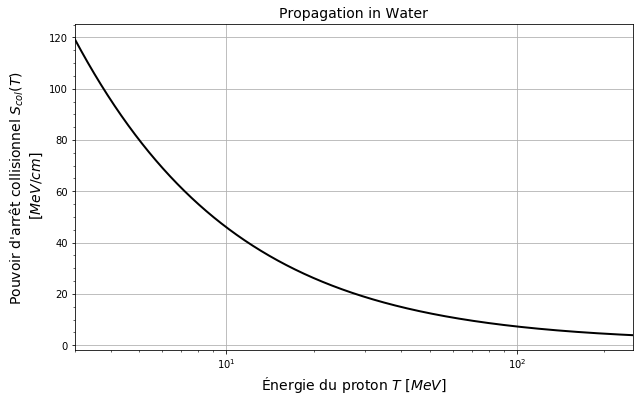

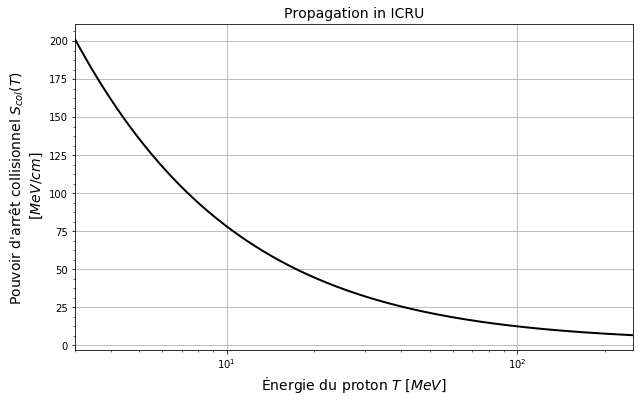

In [6]:
water = Medium(name='Water')
water.plot_S_col()

icru = Medium(name='ICRU')
icru.plot_S_col()

Afin de valider les résultats obtenus, il est possible de tracer les courbes calculées et les courbes provenant des données du NIST sur la même figure et pour le même intervalle d'énergie. Il est important de noter que les courbes précédemment obtenues doivent être divisées par la densité du milieu correspondant puisque les courbes du NIST sont celles du pouvoir collisionnel *massique* qui s'exprime comme $\frac{S_{col}}{\rho}$. Par ailleurs, les courbes du NIST sont celles du pouvoir collisionnel massique *électronique*, qui ne tiennent pas compte des réactions nucléaires possibles dans le milieu. Il est donc logique de croire que ces courbes se rapprocheront beaucoup de nos courbes obtenues.

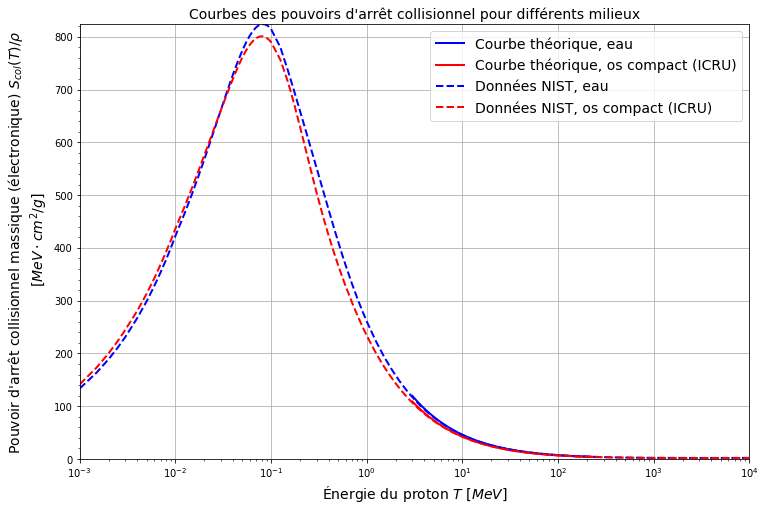

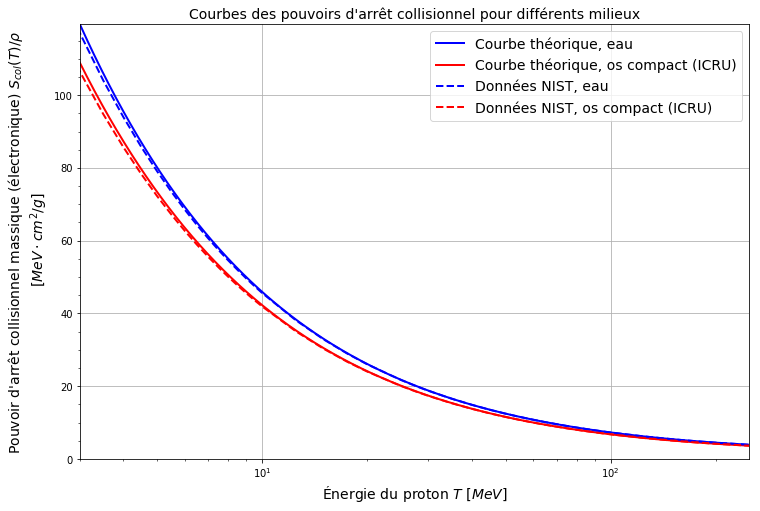

In [7]:
NIST_ICRU = np.loadtxt(fname='Data/NIST_ICRU.txt', skiprows=8)
NIST_WATER = np.loadtxt(fname='Data/NIST_WATER.txt', skiprows=8)

min_energy = 3
max_energy = 250
T = np.arange(min_energy, max_energy, 0.01)
icru_S_col_mass = icru.get_S_col(T)/icru.density
water_S_col_mass = water.get_S_col(T)/water.density

x_bounds = [[min(NIST_WATER[:,0]), max(NIST_WATER[:,0])], [min(T), max(T)]] 
y_bounds = [[0, max(NIST_WATER[:,1])], [0, max(water_S_col_mass)]]

for xlims, ylims in zip(x_bounds, y_bounds):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    line_1, = ax.plot(T, water_S_col_mass, color='b', lw=2, label='Courbe théorique, eau')
    line_2, = ax.plot(T, icru_S_col_mass, color='r', lw=2, label='Courbe théorique, os compact (ICRU)')
    line_3, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,1], color='b', lw=2, ls='--', label='Données NIST, eau')
    line_4, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,1], color='r', lw=2, ls='--', label='Données NIST, os compact (ICRU)')
    ax.set_xscale('log')
    ax.set_title("Courbes des pouvoirs d'arrêt collisionnel pour différents milieux", fontsize=14)
    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel("Pouvoir d'arrêt collisionnel massique (électronique) $S_{col}(T)/ ρ$ \n [$MeV \cdot cm^2/g$]", fontsize=14)
    ax.legend(fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

On remarque que les courbes se rapprochent bien dans l'intervalle où l'approximation utilisée (négliger les termes correctifs) est valide, soit pour des énergies de proton de plus de 3 MeV.

### Question 2

On désire faire l'analyse dimensionnelle de l'équation de la portée des protons dans la matière. On dira que la portée $R_{CSDA}$ est de dimensions homogène s'il existe un facteur, sans unité la liant au terme de l'intégrale de l'inverse du pouvoir d'arrêt total donné par

$$ R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{\frac{S_{c o l}}{\rho}} , $$

où, on sait que la portée $R_{CSDA}$ est exprimée en $[g/cm^2]$ (https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html) et que le pouvoir d'arrêt total est quant à lui exprimé en  $[MeV/cm]$. On obtient donc l'analyse dimensionnelle suivante:

- $MeV$ = $J$ = $kg m^2 s^{-2}$ = $ ML^2T^{-2}$

- $cm$ = $L$

- $g$ = $M$

$$ \dfrac{M L^{-3}}{ML^2 T^{-2} L^{-1}} \cdot ML^2 T^{-2} =  M L^{-2}, $$

ce qui correspond effectivement aux dimensions obtenues avec la portée $R_{CSDA}$ en $[g/cm^2]$. 




### Question 3 

In [8]:
#Probablement juste des explications écrites ici 

### Question 4

Il est nécessaire d'utiliser l'intégration numérique pour calculer la portée des protons puisqu

### Question 5

In [38]:
#Intégration numérique à l'aide de la technique du trapèze

def trapeze_water(T):
    
    return water.density/water.get_S_col(T)

def trapeze_icru(T):
    
    return icru.density/icru.get_S_col(T)

N = 100
a = 3
b = 150
h = (b-a)/N

s_water = 0.5*trapeze_water(a) + 0.5*trapeze_water(b)
for k in range(1,N):
     s_water += trapeze_water(a+k*h)
        
I_water = h*s_water


s_icru = 0.5*trapeze_icru(a) + 0.5*trapeze_icru(b)
for k in range(1,N):
    s_icru += trapeze_icru(a+k*h)
    
I_icru = h*s_icru

#Déterminer le nombre de tranche nécessaire 





### Question 6

On désire déterminer analytiquement l'expression de la dérivée du pouvoir d'arrêt en terme de T. On utilise le théorème de dérivation des fonctions composées et les simplifications suivantes:

$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{dS_{\text{col}}(T)}{d \gamma} \cdot \dfrac{d \gamma}{dT} $$ 

$$ a = 2m_ec^2, b = 1 + (\dfrac{m_e}{m_p})^2, \gamma = 2 \dfrac{m_e}{m_p} $$

$$ U = 2\pi r_e^{2}m_e c^2 n_e,  k = \dfrac{a^2}{I^2} $$

$$ \gamma ^2 \beta^2 = (\gamma ^2 -1) $$

Après les simplications, on peut exprimer $S_{\text{col}}(T)$ de la façon suivante:

$$ S_{\text{col}}(T) = U \cdot \left ( \left (1 - \dfrac{1}{\gamma ^2} \right) \ln \left (\dfrac{k(\gamma ^2 -1)^2}{b+\delta \gamma} \right ) - 2 \right ) $$

La dérivée du pouvoir d'arrêt par rapport à $\gamma$ est donnée par

$$ S_{\text{col}}(T) = U \cdot \left (\dfrac{2}{\gamma^3}  \ln \left (\dfrac{k(\gamma^2 -1)^2}{b + \delta \gamma} \right) + \left (1 - \dfrac{1}{\gamma^2} \right ) \left (\dfrac{4b \gamma + 3 \delta \gamma^2 + \gamma}{(\gamma ^2 -1)(b+\delta \gamma)} \right ) \right) $$

De plus,

$$ T = (\gamma -1) m_p c^2 \Rightarrow \gamma = \dfrac{T}{m_p c^2} +1 $$

Alors,

$$\dfrac{d \gamma}{dT} = \dfrac{1}{c^2 m_p} $$

On obtient donc l'expression de la dérivée de $S_{\text{col}}(T)$ par rapport à $T$,

$$ S_{\text{col}}(T) = \dfrac{U}{c^2 m_p} \cdot \left (\dfrac{2}{\gamma^3}  \ln \left (\dfrac{k(\gamma^2 -1)^2}{b + \delta \gamma} \right) + \left (1 - \dfrac{1}{\gamma^2} \right ) \left (\dfrac{4b \gamma + 3 \delta \gamma^2 + \gamma}{(\gamma ^2 -1)(b+\delta \gamma)} \right ) \right) $$

On obtient alors l'expression suivante en substituant les simplifications effectuées:

$$ S_{\text{col}}(T) = \dfrac{2\pi r_e^{2}m_e c^2 n_e}{c^2 m_p} \cdot \left (\dfrac{2}{\left (\dfrac{T}{m_p c^2} +1 \right )^3}  \ln \left (\dfrac{k \left ( \left (\dfrac{T}{m_p c^2} +1 \right )^2 -1 \right)^2}{\left (\dfrac{m_e}{m_p}\right )^2 + 2 \dfrac{m_e}{m_p} \left (\dfrac{T}{m_p c^2} +1 \right )} \right) + \left (1 - \dfrac{1}{\left (\dfrac{T}{m_p c^2} +1 \right )^2} \right ) \left (\dfrac{4 \left (\dfrac{m_e}{m_p} \right )^2 \left (\dfrac{T}{m_p c^2} +1 \right) + 6 \dfrac{m_e}{m_p} \left (\dfrac{T}{m_p c^2} +1 \right )^2 + \dfrac{T}{m_p c^2} +1}{\left ( \left (\dfrac{T}{m_p c^2} +1 \right ) ^2 -1 \right) \left ( \left (\dfrac{m_e}{m_p} \right )^2+2 \dfrac{m_e}{m_p} \dfrac{T}{m_p c^2} +1 \right )} \right ) \right) $$


In [ ]:
#Calcul de la dérivée du pouvoir d'arrêt
U, y, k, b, d, T, c, m_p = sym.symbols('U gamma k b delta T c m_p')

S_col = U*((1-1/y**2)*sym.log((k*(y**2-1)**2)/(b+d*y))-2)
S_dy = sym.diff(S_col, y)

gamma = T/(m_p*c**2) + 1
gamma_dT = sym.diff(gamma, T)

dScol_dT = S_dy*gamma_dT

#lamdafy 

def deriveeScol(T):
    #Définition des constantes
    m_p = sc.proton_mass
    m_e = sc.electron_mass
    c = sc.speed_of_light
    r = sc.physical_constants['classical electron radius'][0]
    #U = (2*sc.pi*r**2*m_e*c**2*n_e)/(c**2*m_p)
    a = 2*m_e*c**2
    b = 1 + (m_e/m_p)**2
    
    